# Introduction

The goal of this project is to analize data from NFL teams spacificly looking at the offenseive and deffenseive score, rush yards, passing yards, and turn overs.

Questions: <br>
- Are there any patterns or trends in a teams preformace over the season? <br>
- Are there common factors that contribute to a teams success or failure?
- Does the teams record corolate with the offenseive yardage, deffenseive yardage, or turn overs?


### Collect & Clean Data

This data was collected From https://www.pro-football-reference.com website 

**Data in our columns:**<br>
**Week**: The week of the football season in which the game was played.<br>
**Day**: The day of the week on which the game was played.<br>
**Date**: The date on which the game was played.<br>
**OT**: Indicates whether the game went into overtime or not.<br>
**Rec**: The record of the team playing the game at the time of the game.<br>
**Opp**: The record of the opposing team at the time of the game.<br>
**Tm**: The total points scored by the team playing the game.<br>
**Opp**: The total points scored by the opposing team.<br>
**1stD**: The number of first downs achieved by the team playing the game.<br>
**TotYd**: The total yards gained by the team playing the game.<br>
**PassY**: The total passing yards gained by the team playing the game.<br>
**RushY**: The total rushing yards gained by the team playing the game.<br>
**TO**: The number of turnovers committed by the team playing the game.<br>
**Offense**: The performance of the team's offense in the game.<br>
**Defense**: The performance of the team's defense in the game.<br>
**Sp. Tms**: The performance of the team's special teams (e.g., kickoffs, punts, returns) in the game.<br>

In [14]:
# Dictonary of the description of every column in the dataset, for less scrolling. 
Description = {
    "Week": "The week of the football season in which the game was played.",
    "Day": "The day of the week on which the game was played.",
    "Date": "The date on which the game was played.",
    "OT": "Indicates whether the game went into overtime or not.",
    "Rec": "The record of the team playing the game at the time of the game.",
    "Opp": "The record of the opposing team at the time of the game.",
    "Tm": "The total points scored by the team playing the game.",
    "Opp": "The total points scored by the opposing team.",
    "1stD": "The number of first downs achieved by the team playing the game.",
    "TotYd": "The total yards gained by the team playing the game.",
    "PassY": "The total passing yards gained by the team playing the game.",
    "RushY": "The total rushing yards gained by the team playing the game.",
    "TO": "The number of turnovers committed by the team playing the game.",
    "Offense": "The performance of the team's offense in the game.",
    "Defense": "The performance of the team's defense in the game.",
    "Sp. Tms": "The performance of the team's special teams (e.g., kickoffs, punts, returns) in the game."
}



'The week of the football season in which the game was played.'

In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:



# Defining a function to get a dictonary of all NFL teams.
class Nfl_stats:
    # Created an init method that sets a default dictonary that has its keays as nfl teams and values as the symbols to those teams
    
    def __init__(self):
        self.teams_symbols_dict = {}
        # setting url we want to get the data from using requests and beautifulsoup to find nfl teams 
        url = "https://www.pro-football-reference.com/teams/"
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'html.parser')
        teams = soup.find("table", id="teams_active")

        # finding the team names in html
        all_team_names = teams.find_all("th", {"class":"left",'data-stat': 'team_name'})

        # team_names and urls for the teams
        team_names = []
        team_urls = []
        
        # parse throught data
        for i in all_team_names[1:]:
            team_links = i.find("a")
            team_names.append(team_links.text.lower())
            team_urls.append(team_links.get("href").split("/")[2])
            
        # updating teams_symbols_dict to show teams and symbols for those teams
        self.teams_symbols_dict.update(dict(zip(team_names, team_urls)))
        
            
        
    # Creating a dataframe that shows a team's stats for the season
    
    def team_stats(self, team, year):
        
        # using the teams and symbols dictonary to find the each teams data
        teams_dict = self.teams_symbols_dict
        url = "https://www.pro-football-reference.com/teams/"

        #making it easier to find the team's name in the teams_symbols_dict even if its uppercase or just the teams name not the city.
        full_team_name = ""
        for correct_team in teams_dict:
            if team in correct_team:
                full_team_name = correct_team
        
        # finding the team's stats 
        team_symbol = teams_dict[full_team_name.lower()]
        url = f"{url}{team_symbol}/{year}.htm"
        html = requests.get(url).text
        soup = BeautifulSoup(html, "html.parser")
        table = soup.find("table", id="games")

        table_rows = table.find_all("tr")[2:]
        data = []
        for tr in table_rows:
            data.append([table_data.get_text(strip=True) for table_data in tr.find_all("td")])

        # creating a dataframe with the team's stats
        df = pd.DataFrame(data)
        
        # only getting the data from the columns that are relevent to the teams stats
        index = [0,1,4,6,8,9,10] + list(range(11,21))
        new_data = df.iloc[:,index].copy()

        # finding column names
        columns_html = table.find_all("th", {"scope":"col"})
        columns = []

        for col in columns_html[1:]:
            columns.append(col.text)
        # changing some column names and some that are duplicate so then we dont change both in dataframe later on
        columns[4] = "Result"
        columns[17] = "Toyd"
        columns[10] = "opp"
        columns[-4] = "Defense_TO"
        columns[-5] = "Defense_RushY"
        columns[-6] = "Defense_PassY"
        columns[-8] = "Defense_1stD"
        new_data.columns = [columns[num] for num in index]
        # renaming columns in our dataframe so the stats match up
        team_stats_df = new_data.rename({
            "Rec": "Record", 
            "Opp": "Opposing_team",
            "Tm":"Team_score",
            "TotYd": "Offense_TotYd",
            "Toyd": "Defense_TotYd",
            "opp": "Opp_score",
            "TO":"Offense_TO",
            "RushY": "Offense_RushY",
            "PassY": "Offense_PassY",
            "1stD": "Offense_1stD"


        }, axis="columns")

        # replacing some columns into numbers so then we can do better analysis
        result_encoder = {'Result': {'L': 0, 'T': 0,'W': 1,' ' : pd.NA}}
        team_stats_df.replace(result_encoder, inplace=True)
        
        # creating a week column so we know what week it is in the season
        week = list(range(1,len(team_stats_df) + 1))
        team_stats_df.insert(0, "Week", week)

        # creting a column for the team we wanted to see and making the first letter a capitol letter.
        team_name_col = pd.Series([f"{team.title()}"]).repeat(len(team_stats_df)).reset_index(drop=True)

        team_stats_df.insert(0,"Team_name", team_name_col)
        
        # making that need to be numbers into int's
        columns_int_list = ["Result","Team_score","Opp_score","Offense_1stD","Offense_TotYd","Offense_PassY","Offense_RushY","Offense_TO","Defense_1stD","Defense_TotYd","Defense_PassY","Defense_RushY","Defense_TO"]
        for column in columns_int_list:
            columns_list_na = team_stats_df[column].replace(["","bye"],0)
            team_stats_df[column]= columns_list_na.astype(int)
        
        return team_stats_df


### Explore Data

In [11]:
# calling the  
# to create an object we call Nfl_stats().team_stats("team name", Year)
team_data = Nfl_stats().team_stats("seahawks", 2022)


In [4]:
rows = team_data.shape[0]
columns = team_data.shape[1]
print(f"There are {rows} rows and {columns} coulumns within this dataset.")


There are 20 rows and 19 coulumns within this dataset.


In [5]:
num_teams_played = team_data[team_data["Opposing_team"] != "Bye Week"].groupby("Opposing_team").size().count()

print("Number of teams played against: " + str(num_teams_played))


teams_played = team_data.groupby("Opposing_team").size()
teams_played = teams_played[teams_played.index != "Bye Week"]
print("\n"
      "Breakdown of teams they played: \n",
      teams_played)

print("\nTeams played more than once: \n" +f"{str(teams_played[teams_played == 2])}")



Number of teams played against: 15

Breakdown of teams they played: 
 Opposing_team
                        1
Arizona Cardinals       2
Atlanta Falcons         1
Carolina Panthers       1
Denver Broncos          1
Detroit Lions           1
Kansas City Chiefs      1
Las Vegas Raiders       1
Los Angeles Chargers    1
Los Angeles Rams        2
New Orleans Saints      1
New York Giants         1
New York Jets           1
San Francisco 49ers     3
Tampa Bay Buccaneers    1
dtype: int64

Teams played more than once: 
Opposing_team
Arizona Cardinals    2
Los Angeles Rams     2
dtype: int64


In [6]:
missing_values = team_data.isna().sum()

print("The amount of missing values for this dataset in each column: \n\n" + str(missing_values))

The amount of missing values for this dataset in each column: 

Team_name        0
Week             0
Day              0
Date             0
Result           0
Record           0
Opposing_team    0
Team_score       0
Opp_score        0
Offense_1stD     0
Offense_TotYd    0
Offense_PassY    0
Offense_RushY    0
Offense_TO       0
Defense_1stD     0
Defense_TotYd    0
Defense_PassY    0
Defense_RushY    0
Defense_TO       0
dtype: int64


In [7]:
unique_days = team_data.Day.unique()[team_data.Day.unique() != ""]
print(f"Unique days played: {unique_days}")

num_unique_days_played = team_data[team_data.Day != ""].groupby("Day")["Day"].count()

print(f"\nCount of days team played: \n{num_unique_days_played}")

team_result = team_data.Result
print(f"\nGames won: {str(team_result.sum())}")
print(f"Games lost: {str(team_result.count()-team_result.sum())}")


Unique days played: ['Mon' 'Sun' 'Thu' 'Sat']

Count of days team played: 
Day
Mon     1
Sat     2
Sun    14
Thu     1
Name: Day, dtype: int64

Games won: 9
Games lost: 11


### Analyze Data

In [8]:
won_against = team_data[team_data.Result == 1].Opposing_team
print(f"\nWon against: \n{won_against.to_string(index=False)}")

lost_against = team_data[team_data.Result == 0].Opposing_team
print(f"\nLost against: \n{lost_against.to_string(index=False)}")


Won against: 
      Denver Broncos
       Detroit Lions
   Arizona Cardinals
Los Angeles Chargers
     New York Giants
   Arizona Cardinals
    Los Angeles Rams
       New York Jets
    Los Angeles Rams

Lost against: 
 San Francisco 49ers
     Atlanta Falcons
  New Orleans Saints
Tampa Bay Buccaneers
            Bye Week
   Las Vegas Raiders
   Carolina Panthers
 San Francisco 49ers
  Kansas City Chiefs
                    
 San Francisco 49ers


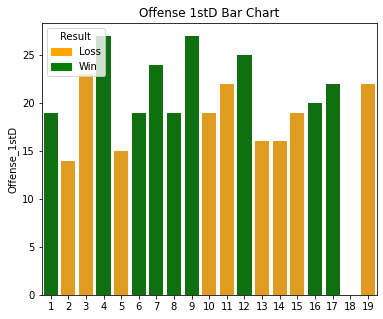

The offense's average number of 1stD's when the result is a win: 22.44
The offense's average number of 1stD's when the ressult is a loss: 16.6


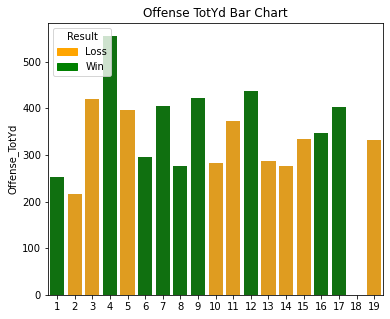

The offense's average number of TotYd's when the result is a win: 376.89
The offense's average number of TotYd's when the ressult is a loss: 291.6


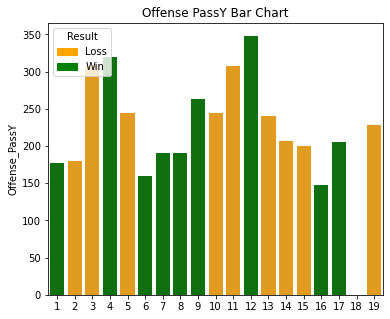

The offense's average number of PassY's when the result is a win: 222.44
The offense's average number of PassY's when the ressult is a loss: 216.0


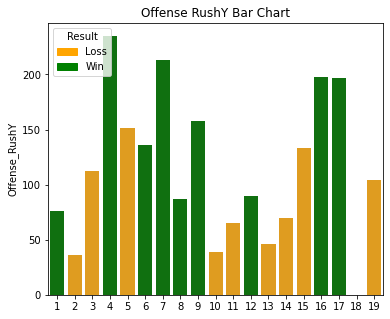

The offense's average number of RushY's when the result is a win: 154.44
The offense's average number of RushY's when the ressult is a loss: 75.6


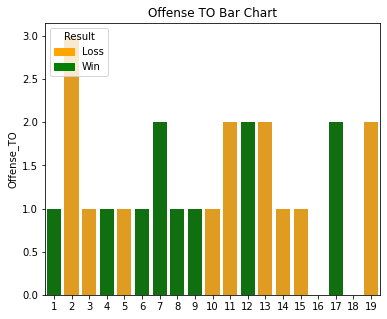

The offense's average number of TO's when the result is a win: 1.22
The offense's average number of TO's when the ressult is a loss: 1.4


In [10]:
team_data.index = range(1,len(team_data)+1)

team_data = team_data[team_data["Opposing_team"] != "Bye Week"]




def offense_bargraphs(data):
    offense_stats = data.filter(regex="Offense").copy()

    offense_stats["Result"] = data.Result.values
    lst = []
    for game in offense_stats.iloc[:,:-1]:
        fig = plt.figure(figsize=(6,5))
        plot = sns.barplot(x=offense_stats.index, y=game, data=offense_stats, hue="Result",dodge=False, palette={1: "green", 0: "orange"});
        legend_elements = [plt.Rectangle((0,0), 1, 1, color='orange', label='Loss'),plt.Rectangle((0,0), 1, 1, color='green', label='Win')]
        legend = plt.legend(handles= legend_elements,title="Result",labels=["Loss", "Win"], loc="upper left")
        title = game.split("_")
        chart_title = plt.title(title[0]+ " " + title[1] +" Bar Chart")
        
        lst = fig, plot, legend_elements, legend, chart_title
        plt.show()
        offense_mean_win = round(data[team_data["Result"]== 1][game].mean(),2)
        offense_mean_loss = round(data[team_data["Result"]== 0][game].mean(),2)
        print(f"The offense's average number of {title[1]}'s when the result is a win: {str(offense_mean_win)}")
        print(f"The offense's average number of {title[1]}'s when the ressult is a loss: {str(offense_mean_loss)}")
    return lst
offense_bargraphs(team_data);

### Interpret Results

### Conclusions